### Hypotheses
- [Lower ripple rate during SD compared NSD](#ripple_rate): One possibility of faster decay of replay during sleep deprivation could be reduced ripple rate at the beginning of POST. This may suggest that in order for cells to replay they need sufficient number/amount of elicitation to last for certain duration of time, so a lower ripple rate could interrupt this requirement.


### Create ripple file backup

In [ ]:
import numpy as np
import subjects

sessions = (
    subjects.sd.ratJday1
    + subjects.sd.ratKday1
    + subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratRday2
    + subjects.sd.ratUday1
    + subjects.sd.ratUday4
    + subjects.sd.ratVday2

    + subjects.nsd.ratJday2
    + subjects.nsd.ratKday2
    + subjects.nsd.ratNday2
    + subjects.nsd.ratSday2
    + subjects.nsd.ratRday1
    + subjects.nsd.ratUday2
    + subjects.nsd.ratVday1
    + subjects.nsd.ratVday3

)


In [ ]:
for sub,sess in enumerate(sessions):
    sess.ripple.save(sess.filePrefix.with_suffix('.ripples.bak.03-08-2022'))

### Detect ripples for multiple sessions together

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy.plotting import Fig
import pandas as pd
from scipy import stats
import subjects

sessions = (
    subjects.sd.ratJday1
    + subjects.sd.ratKday1
    + subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratRday2
    + subjects.sd.ratUday1
    + subjects.sd.ratUday4
    + subjects.sd.ratVday2

    + subjects.nsd.ratJday2
    + subjects.nsd.ratKday2
    + subjects.nsd.ratNday2
    + subjects.nsd.ratSday2
    + subjects.nsd.ratRday1
    + subjects.nsd.ratUday2
    + subjects.nsd.ratVday1
    + subjects.nsd.ratVday3
)


# sessions = subjects.sd.utkuAG_day1 + subjects.sd.utkuAG_day2


In [ ]:
from tqdm.notebook import tqdm
from neuropy.analyses.oscillations import detect_ripple_epochs

for sub, sess in enumerate(tqdm(sessions)):

    try:
        artifact = sess.artifact
    except:
        artifact = None

    # channels = sess.ripple.metadata['channels'] 
    signal = sess.eegfile.get_signal()
    ripples = detect_ripple_epochs(
        signal, probegroup=sess.probegroup, freq_band=(125, 250), ignore_epochs=artifact
    )

    # ripples.save(sess.filePrefix.with_suffix('.ripple.npy'))
    ripples.save(sess.filePrefix.with_suffix('.ripple.no_merge.npy'))


### Ripple band SNR across channels and depth visualization

In [1]:
import numpy as np
import subjects

sessions = subjects.sd.ratUday4

In [12]:
from neuropy.utils.signal_process import hilbertfast,filter_sig

for sub,sess in enumerate(sessions):
    probe_layout = sess.probegroup.to_dataframe()
    probe_layout = probe_layout[probe_layout.connected]
    good_chans = probe_layout.channel_id.values
    post = sess.paradigm['post'].flatten()
    t_start,t_stop = [post[0]+5*3600, post[0]+7*3600] 

    snr=[]
    for chan in  good_chans:
        signal = sess.eegfile.get_signal(chan,t_start=t_start,t_stop=t_stop)
        rpl_bp = filter_sig.bandpass(signal,lf=0.5,hf=4).traces[0]
        hilbert_amp = np.abs(hilbertfast(rpl_bp))
        snr.append(np.std(hilbert_amp))


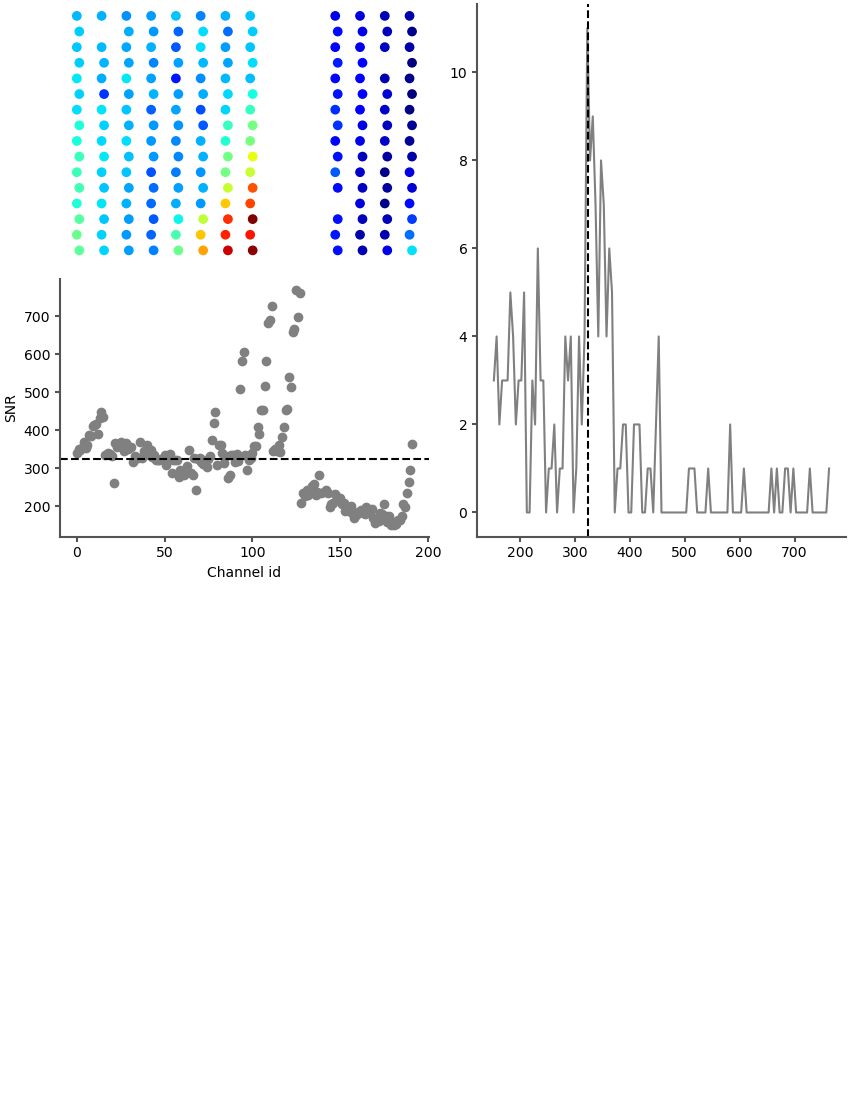

In [14]:
%matplotlib widget
import matplotlib.pyplot as plt
from neuropy.plotting import Fig

snr = np.asarray(snr)

fig = Fig(grid=(4,2), fontsize=10,dpi=100)
ax = fig.subplot(fig.gs[0])
ax.scatter(probe_layout.x, probe_layout.y, c=snr, cmap="jet")
ax.axis("off")

ax = fig.subplot(fig.gs[1, 0])
ax.scatter(good_chans, snr, color="gray")
ax.axhline(np.median(snr), color="k", ls="--")
ax.set_ylabel("SNR")
ax.set_xlabel("Channel id")

ax = fig.subplot(fig.gs[:2, 1])
bins = np.arange(snr.min(), snr.max(), 5)
hist_snr = np.histogram(snr, bins)[0]
ax.plot(bins[:-1] + 2.5, hist_snr, color="gray")
ax.axvline(np.median(snr), color="k", ls="--")


### Detecting noisy ripples using PCA/KMeans
- Since faster-oscillation artifacts have power in ripple band, these may get picked up during ripple detection based on hilbert transform. These ripple-like artifacts can possibly be eliminated using clustering algorithms.  

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy.plotting import Fig
import pandas as pd
from scipy import stats
import subjects

sessions = subjects.sd.ratNday1

In [ ]:
from neuropy.utils.signal_process import hilbertfast, filter_sig
from sklearn.decomposition import PCA

for sub, sess in enumerate(sessions):
    good_chans = np.concatenate(sess.probegroup.get_connected_channels())
    pca_ripples = []
    for i in range(len(sess.ripple)):
        rpls = sess.ripple[i].flatten()
        signal = sess.eegfile.get_signal(good_chans.astype("int"), rpls[0], rpls[1])
        hilbert_amp = np.abs(
            hilbertfast(filter_sig.bandpass(signal.traces, lf=130, hf=250, ax=-1), ax=1)
        )

        pca = PCA(n_components=1).fit_transform(hilbert_amp)
        pca_ripples.append(pca.reshape(-1))
pca_ripples = np.asarray(pca_ripples)

In [ ]:
from sklearn.cluster import KMeans,DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
from neuropy.core import Epoch
from sklearn.neighbors import LocalOutlierFactor


pca_of_rpl_amp = PCA(n_components=2).fit_transform(pca_ripples)
features = MinMaxScaler().fit_transform(pca_of_rpl_amp) 
labels = GaussianMixture(n_components=2,random_state=0).fit_predict(features)
outliers= LocalOutlierFactor(n_neighbors=20).fit_predict(features)

# starts,stops = sess.ripple.starts,sess.ripple.stops
# weird_ripples = Epoch.from_array(starts[labels==0],stops[labels==0])
# sess.recinfo.write_epochs(weird_ripples,ext='wrp')


In [ ]:
%matplotlib widget

for l in [0,1]:
    plt.plot(features[labels==l,0],features[labels==l,1],'.')

plt.plot(features[outliers==-1,0],features[outliers==-1,1],'k.')

### Bursty ripples SD vs NSD

In [ ]:
import matplotlib.pyplot as plt
from neuropy.utils.signal_process import WaveletSg
import numpy as np
from neuropy.plotting import Fig
import pandas as pd
from tqdm.notebook import tqdm
from scipy import stats
import subjects

sessions = (
    subjects.sd.ratJday1
    + subjects.sd.ratKday1
    + subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratRday2
    + subjects.sd.ratUday1
    + subjects.sd.ratUday4
    + subjects.sd.ratVday2

    + subjects.nsd.ratJday2
    + subjects.nsd.ratKday2
    + subjects.nsd.ratNday2
    + subjects.nsd.ratSday2
    + subjects.nsd.ratRday1
    + subjects.nsd.ratUday2
    + subjects.nsd.ratVday1
    + subjects.nsd.ratVday3
)
rpl_channels = [39,63,111,95,49,117,100,85,63,63,36,188,16,99,86,9]

assert len(rpl_channels)==len(sessions)


In [ ]:
from neuropy.utils.signal_process import filter_sig, hilbertfast
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
from neuropy.analyses.brainstates import hmmfit1d

peak_rate = []
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    zt = np.array([0, 4])
    starts = zt * 3600 + post[0]
    peak_rate_sub = []
    for i, s in enumerate(starts):
        rpls = sess.ripple.time_slice(s, s + 3600)

        srate = sess.eegfile.sampling_rate
        dt = 1 / srate
        smooth_window = 0.008  # 20 ms
        sigma = smooth_window / dt

        rpl_lfp = sess.eegfile.get_frames_within_epochs(rpls, rpl_channels[sub])
        rpl_bp = filter_sig.bandpass(rpl_lfp, fs=1250, lf=125, hf=250)
        hilbert_amp = np.abs(hilbertfast(rpl_bp))

        hilbert_smth = gaussian_filter1d(hilbert_amp, sigma=sigma)
        hilbert_smth_zsc = stats.zscore(hilbert_smth)

        peaks = find_peaks(hilbert_smth_zsc, height=1)[0]
        peak_rate_sub.append(len(peaks) / len(rpls))

    df = pd.DataFrame(dict(zt=zt, peak_rate=peak_rate_sub, grp=sess.tag))
    peak_rate.append(df)

peak_rate = pd.concat(peak_rate, ignore_index=True)


In [ ]:
%matplotlib widget
import seaborn as sns
from neuropy.plotting import Fig

fig = Fig(grid=(3,3),fontsize=12)
ax=fig.subplot(fig.gs[0])
sns.boxplot(
    data=peak_rate, x="zt", y="peak_rate", hue="grp", hue_order=['NSD','SD'],palette=subjects.colors_sd(1.6)
)
sns.swarmplot(
    data=peak_rate,
    x="zt",
    y="peak_rate",
    hue="grp",
    hue_order=['NSD','SD'],
    palette=subjects.colors_sd(1),
    dodge=True,
    size=8,
    # edgecolors='w',
)
ax.set_xticks([0,1],['0-1','4-5'])
ax.set_xlabel('Zt time (h)')
ax.set_ylabel('# hilbert peaks every ripple')
ax.set_title('Amount of ripple merging\nearly vs late')
ax.legend([],frameon=False)
fig.legend(ax,['NSD','SD'],subjects.colors_sd(1.4),x=1,dy=0.06,fontsize=10)


In [ ]:
%matplotlib widget

_,axs= plt.subplots(2,1,sharex=True)
axs[0].plot(rpl_bp)
axs[0].plot(hilbert_amp)
# axs[0].plot(rpl_smth)
axs[0].plot(hilbert_smth,'r')
# axs[0].plot(hilbert_hilbert_amp,'r')
# plt.plot(peaks,hilbert_smth[peaks],'k*')
axs[1].plot(hilbert_smth_zsc)
axs[1].plot(peaks,hilbert_smth_zsc[peaks],'k*')

# axs[1].plot(states)